<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

You should consider upgrading via the 'c:\users\joaqu\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: c:\Users\joaqu\OneDrive\Documentos\drive\uba\nlp\procesamiento_lenguaje_natural\clase_5\ejercicios\clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:02<00:00, 3.11MB/s]


In [6]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [7]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


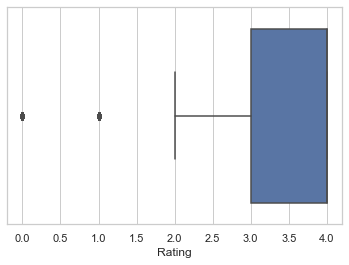

In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_reviews['Rating'])

unique, counts = np.unique(df_reviews['Rating'], return_counts=True)

print(dict(zip(unique, counts)))

In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
import numpy as np

review_np = np.array(df_reviews['Rating'])
print(review_np[:5])

[3 4 2 4 4]


In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
print(len(review_np))

22641


In [12]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus_review = ''.join(df_reviews['Review Text'])

In [14]:
# Alumno: ¿Cuál es la longitud de ese corpus?

word_list = corpus_review.split()

number_of_words = len(word_list)
print(number_of_words)

1340273


In [15]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

list_corpus=text_to_word_sequence(
    corpus_review,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' '
)

In [16]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print(list_corpus[:20])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortablelove', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a', 'store']


In [17]:
# Alumno: ¿Cuántos tokens/palabras hay?
print(len(list_corpus))

1366924


In [48]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list_corpus)

In [49]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

config= tokenizer.get_config()
for i in config:
    print(i)

# print(config["index_word"][1:100])
print(config["index_word"][-100:])
print(len(config["index_word"]))

num_words
filters
lower
split
char_level
oov_token
document_count
word_counts
word_docs
index_docs
index_word
word_index
17625": "camoflauges", "17626": "butyes", "17627": "dcute", "17628": "blaring", "17629": "platinum"}
339730


In [57]:
# Alumno: Convertir las palabras/tokens a números

sequence_data = tokenizer.texts_to_sequences(df_reviews["Review Text"])

In [68]:
# Alumno: Determinar cual es la oración más larga
large = max(sequence_data, key=len)
large_to_text = tokenizer.sequences_to_texts([large])
print(large_to_text, len(large))

["i love maeve tops i love the material and feel of this brand when i saw the new tops that came out i ran to my local store to try one on i'm usually a large in a top once in a while an xl they only had a large to try so i tried it in the black motif i could barely get the top on it looked like i was missing 1 2 of the top i checked the size and it was a large it's a shame the top is really cute if you are the least bit broad or busty go up a size or two if you are usually a"] 115


In [69]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.utils import pad_sequences
maxlen = 115

sequence_data_pad = pad_sequences(sequence_data, maxlen=maxlen)

In [70]:
# Alumno: Observar las dimensiones de la variable input

sequence_data_pad.shape

(22641, 115)

In [73]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

from tensorflow import one_hot

y = one_hot(df_reviews["Rating"] ,5)
y.shape

TensorShape([22641, 5])

In [83]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sequence_data_pad, np.array(y), test_size=0.2, random_state=42)

In [84]:
# Alumno: determinar la dimensiones de entrada y salida
inp_dim = sequence_data_pad.shape[1]
out_dim = y.shape[1]

### 2 - Entrenar el modelo con Embeddings + LSTM

In [85]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
import tensorflow

In [154]:
model = tensorflow.keras.Sequential([
    Embedding(
        input_dim=2001,
        output_dim=64),
    tensorflow.keras.layers.Bidirectional(LSTM(64)),
    tensorflow.keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    tensorflow.keras.layers.Dense(out_dim, activation='softmax')
])

In [155]:
model.compile(loss="categorical_crossentropy", 
optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.2
)

Epoch 1/30
453/453 [==============================] - 74s 118ms/step - loss: 1.0139 - categorical_accuracy: 0.5908 - val_loss: 0.9344 - val_categorical_accuracy: 0.6174
Epoch 2/30
453/453 [==============================] - 69s 151ms/step - loss: 0.8751 - categorical_accuracy: 0.6263 - val_loss: 0.9464 - val_categorical_accuracy: 0.6147
Epoch 3/30
453/453 [==============================] - 54s 120ms/step - loss: 0.8063 - categorical_accuracy: 0.6592 - val_loss: 0.9133 - val_categorical_accuracy: 0.6268
Epoch 4/30
453/453 [==============================] - 44s 98ms/step - loss: 0.7664 - categorical_accuracy: 0.6738 - val_loss: 0.9091 - val_categorical_accuracy: 0.6254
Epoch 5/30
453/453 [==============================] - 42s 94ms/step - loss: 0.7190 - categorical_accuracy: 0.6956 - val_loss: 0.9336 - val_categorical_accuracy: 0.6174
Epoch 6/30
453/453 [==============================] - 43s 96ms/step - loss: 0.6884 - categorical_accuracy: 0.7101 - val_loss: 0.9618 - val_categorical_accura

loss
categorical_accuracy
val_loss
val_categorical_accuracy


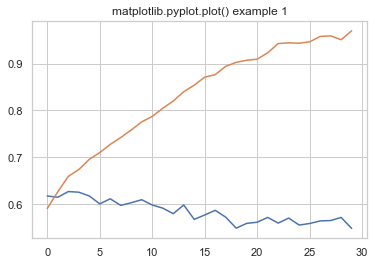

In [156]:
for i in history.history:
    print(i)
# history.history["loss"][-50:]
history.history["val_categorical_accuracy"]

import matplotlib.pyplot as plt 

plt.plot(history.history["val_categorical_accuracy"])
plt.plot(history.history["categorical_accuracy"])
plt.title('matplotlib.pyplot.plot() example 1') 
plt.draw() 
plt.show() 

In [150]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
36/36 [==============================] - 3s 85ms/step - loss: 1.4903 - categorical_accuracy: 0.6012
test loss, test acc: [1.4903432130813599, 0.6012364625930786]


In [168]:
def text_to_sequence(text):
    sequence = tokenizer.texts_to_sequences([text])
    sequence = pad_sequences(sequence, maxlen=maxlen)
    return sequence

print(model.predict([text_to_sequence("The fabric was of poor quality, but it looks great.")]))
 

1/1 [==============================] - 0s 52ms/step
[[0.1928555  0.00097345 0.00114088 0.0177157  0.7873145 ]]
